In [75]:
import librosa
import pandas as pd
import numpy as np
import noisereduce as nr
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import re
import pyarabic.araby as araby
from pyarabic.normalize import normalize_hamza as normalize_text
import string
from IPython.display import Audio, display


### Loading audio

In [88]:
audio_path='Dataset/data/0a3FHR_462.mp3'
y,sr=librosa.load(audio_path)

In [48]:
y

array([0.00501622, 0.01110172, 0.01049589, ..., 0.03225096, 0.03000596,
       0.0293567 ], dtype=float32)

In [49]:
sr

22050

### Preprocessing and EDA

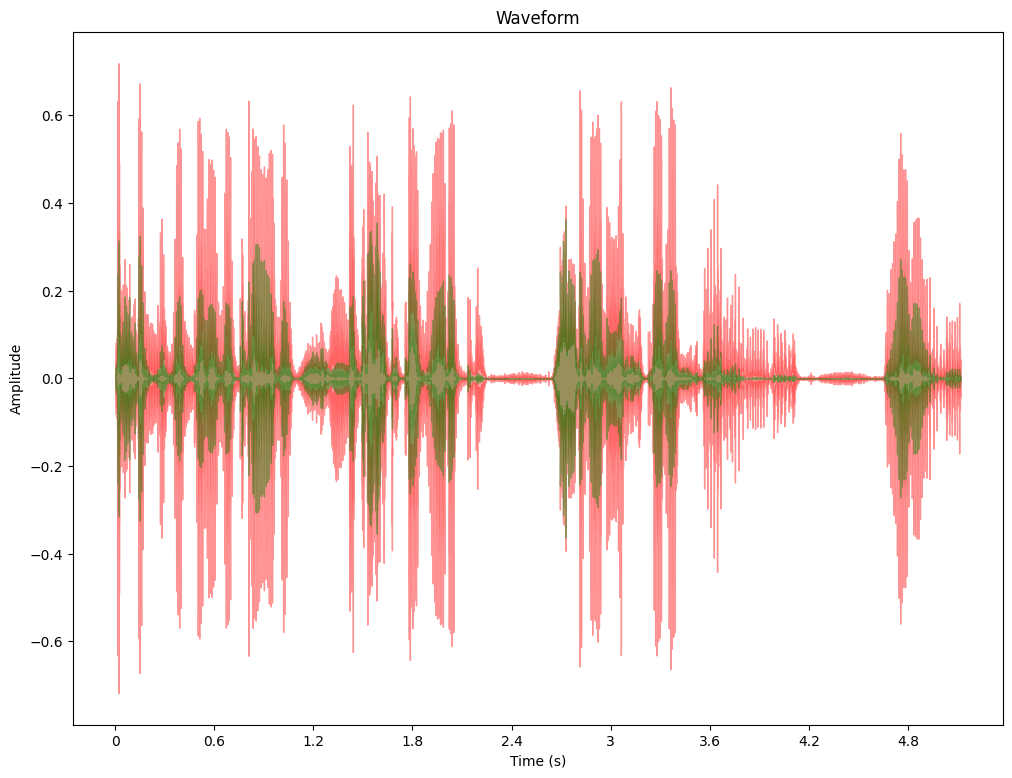

In [ ]:
#Removing Noise and Plotting before and after
FIG_SIZE = (5, 5)
y_reduced=nr.reduce_noise(y, sr)
librosa.display.waveshow(y,  alpha=0.4,color='r')
librosa.display.waveshow(y_reduced,  alpha=0.4,color='g')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()
y_reduced=nr.reduce_noise(y, sr)

In [27]:
print("Shape of Initial Data : "+ str(y.shape))
#Audio is Monophonic as it is from a sigle channel eliminating the complexity of processing/cleaning higher dimensional audios

Shape of Initial Data : (112896,)


Original Sampling Rate : 22050 Hz


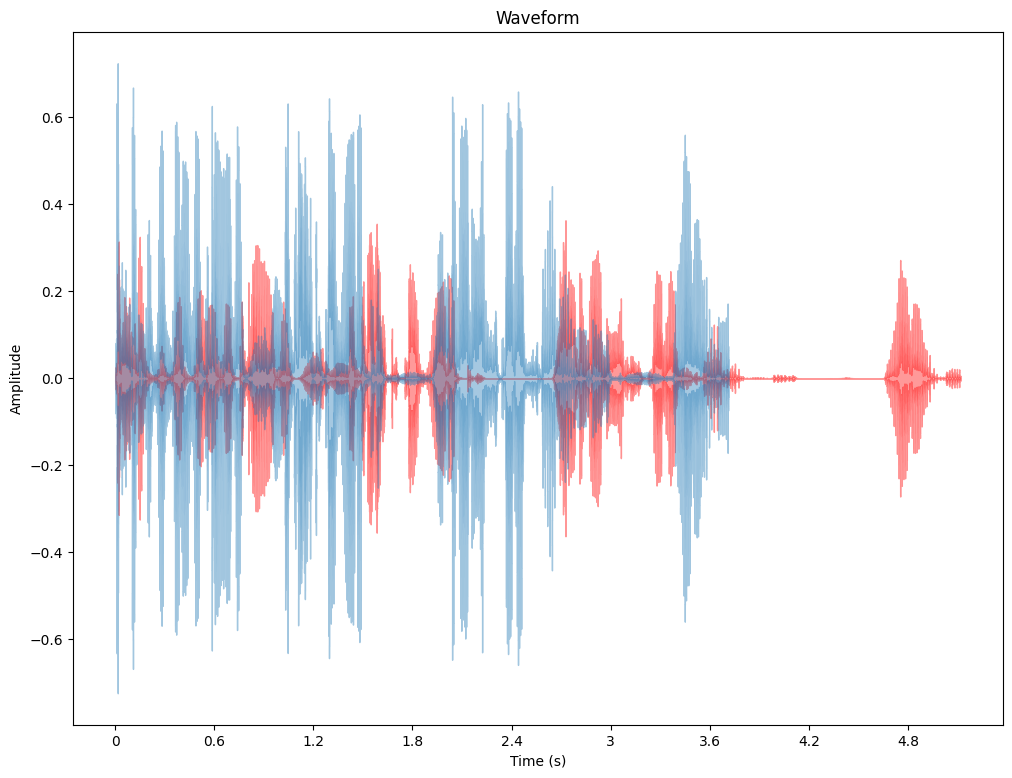

rate after downsampling : 16000


In [59]:
print("Original Sampling Rate : "+str(sr)+" Hz")
target_sr = 16000
y_downsampled=librosa.resample(y,orig_sr=sr,target_sr=target_sr)
Fig_SIZE = (10, 5)
librosa.display.waveshow(y_reduced,  alpha=0.4,color='r')
librosa.display.waveshow(y_downsampled,  alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()
print("rate after downsampling : "+ str(target_sr))

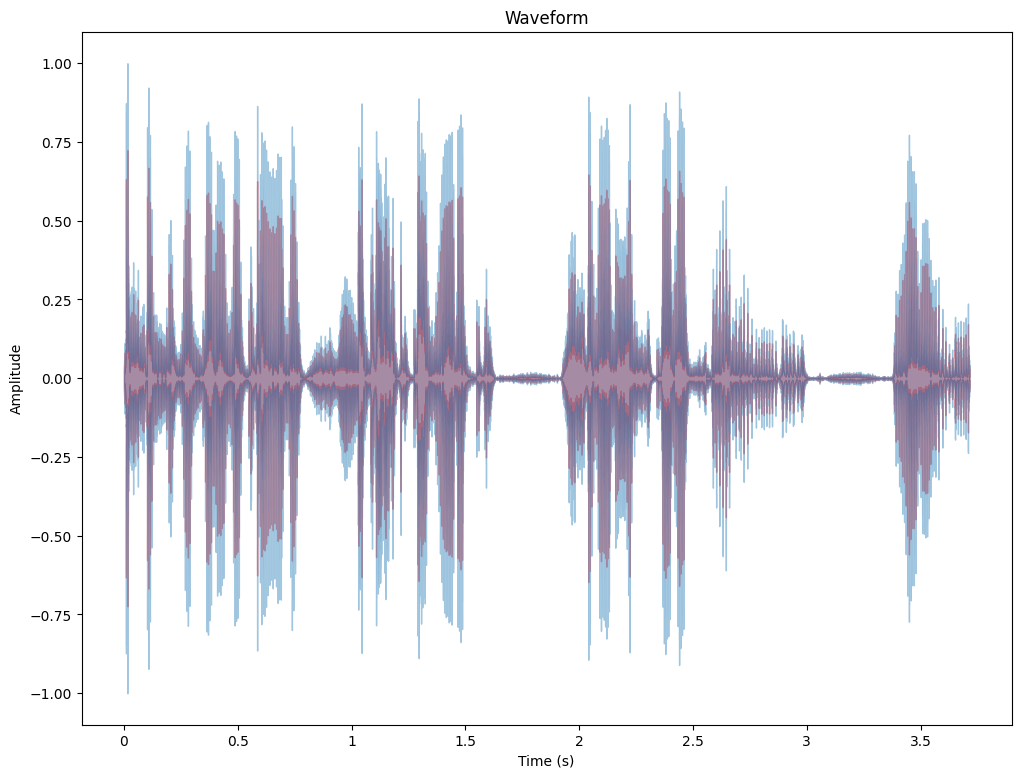

In [60]:
#Normalizing waveform
y_normalized=librosa.util.normalize(y_downsampled)
librosa.display.waveshow(y_downsampled,  alpha=0.4,color='r')
librosa.display.waveshow(y_normalized,  alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

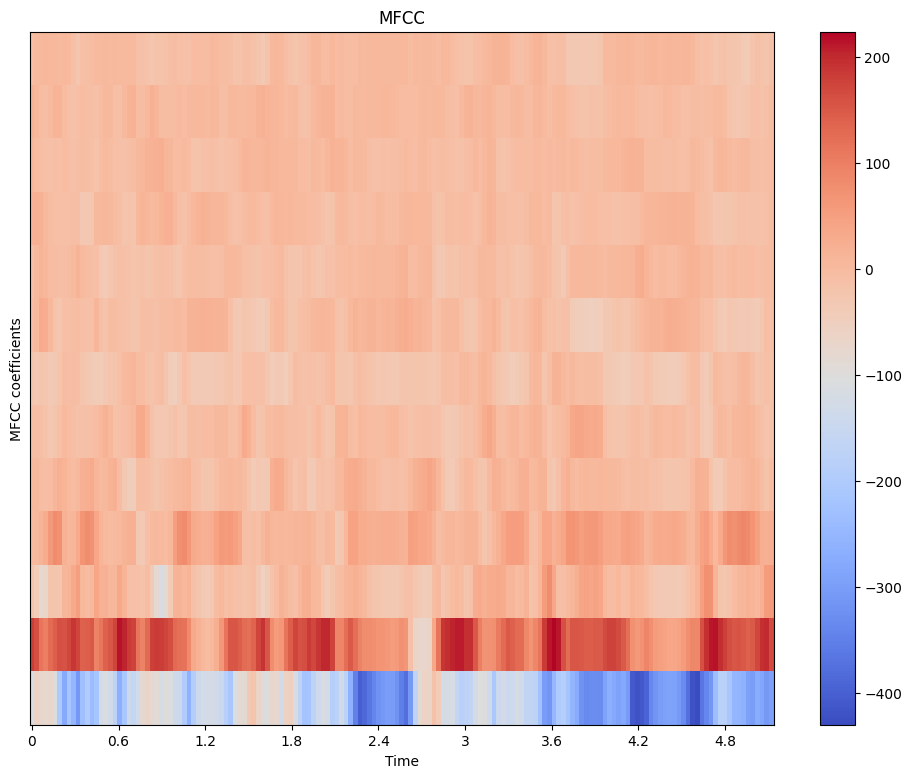

In [62]:
#Extracting MFCC and plotting
mfccs = librosa.feature.mfcc(y=y_normalized, sr=target_sr, n_mfcc=13)
FIG_SIZE=(10,5)
librosa.display.specshow(mfccs, sr=target_sr, x_axis='time')
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCC")
plt.show()

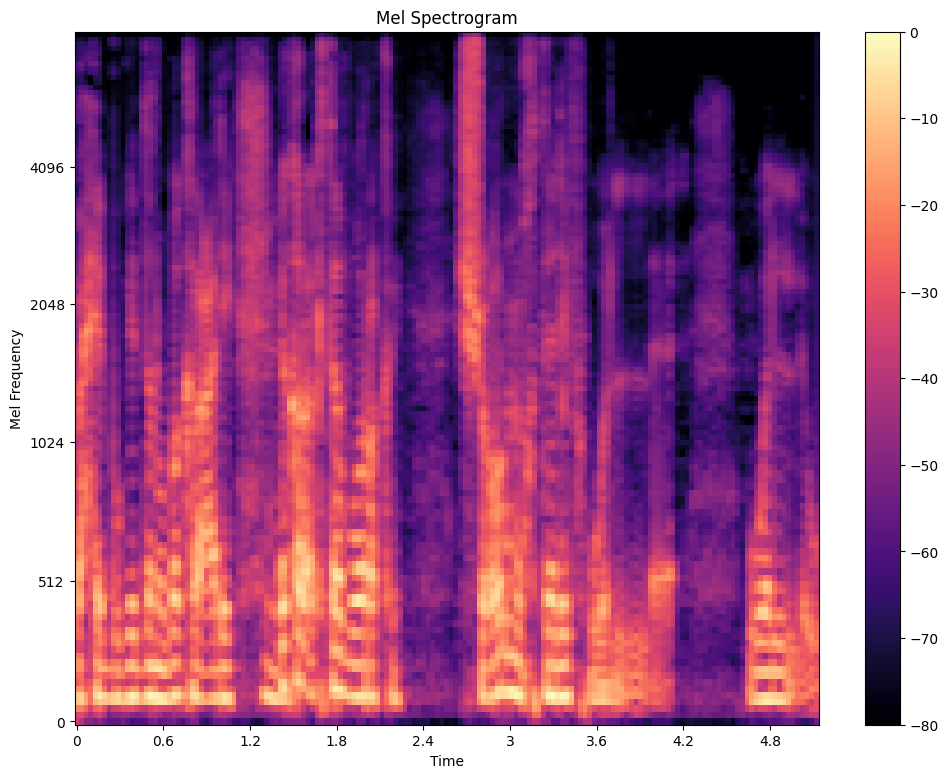

In [80]:
#MEL SPECTROGRAM
mel_spectrogram = librosa.feature.melspectrogram(y=y_normalized, sr=target_sr)
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), sr=target_sr, x_axis='time', y_axis='mel')
plt.xlabel("Time")
plt.ylabel("Mel Frequency")
plt.colorbar()
plt.title("Mel Spectrogram")
plt.show()
Audio(y_normalized, rate=target_sr)

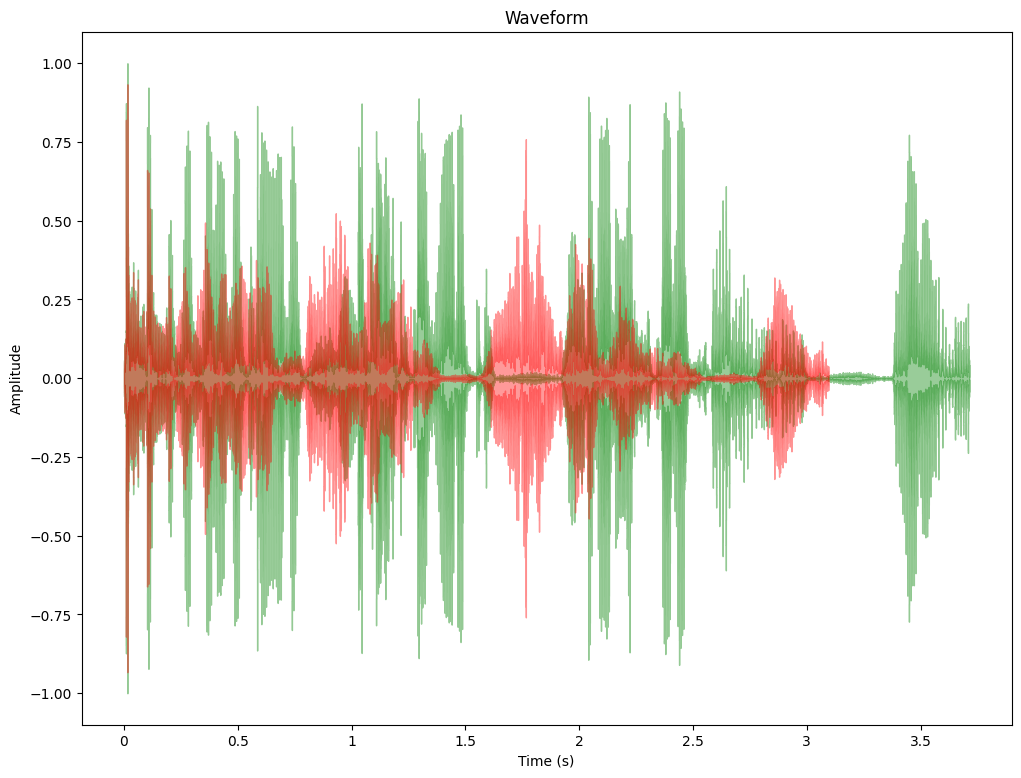

In [83]:
#Time masking
time_masked = librosa.effects.time_stretch(y_normalized, rate=1.2)
librosa.display.waveshow(y_normalized,  alpha=0.4,color='g')
librosa.display.waveshow(time_masked,  alpha=0.4,color='r')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()
Audio(time_masked, rate=target_sr)

### Processing Transcriptions 

In [84]:
import pandas as pd

In [85]:
df=pd.read_csv('Dataset/index.csv')

In [87]:
df.columns

Index(['audio_file', 'text', 'gender'], dtype='object')

'0a3FHR_462.mp3'

In [91]:
transcription=(df['audio_file']==audio_path.split('/')[-1])

In [100]:
transcription

'بحبه جدا وبقرا عليه اقرا كتاب ورقي'

In [95]:
# Expression Processing
def preprocess_arabic_text(text):
    text = araby.strip_tashkeel(text)
    text = normalize_text(text)
    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!"…"–ـ'''
    all_punctuations = string.punctuation + arabic_punctuations
    translator = str.maketrans('', '', all_punctuations)
    text = text.translate(translator)
    text = re.sub(' +', ' ', text)
    return text.strip()

In [101]:
transcription=preprocess_arabic_text(transcription)

In [102]:
transcription

'بحبه جدا وبقرا عليه اقرا كتاب ورقي'

### Text to semantic modeling

In [120]:
import torch
from transformers import AutoTokenizer, AutoModel
device = torch.device("mps" if torch.mps.is_available() else "cpu")
device

device(type='mps')

In [121]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] 
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [122]:

sentences = transcription

# Sentences we want sentence embeddings for
sentences = ['This is an example sentence', 'Each sentence is converted']

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
model = AutoModel.from_pretrained('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling. In this case, max pooling.
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

print("Sentence embeddings:")
print(sentence_embeddings)

Sentence embeddings:
tensor([[ 0.1885,  0.1743,  0.0545,  0.2905,  0.1677, -0.0472,  0.6456,  0.1598,
          0.2269, -0.0309,  0.2559, -0.0526, -0.2261, -0.0571,  0.1304,  0.1250,
          0.3175,  0.1944, -0.5863, -0.0126,  0.6099,  0.1643,  0.0333, -0.2738,
         -0.2898, -0.2112, -0.0226, -0.1704,  0.1616,  0.0608, -0.2416,  0.1858,
          0.4274,  0.1930, -0.0723,  0.1661,  0.1044,  0.2048,  0.2112,  0.1997,
         -0.0941, -0.1738,  0.0643,  0.2803, -0.2953,  0.0621,  0.1043, -0.0236,
          0.1291, -0.1262, -0.1790,  0.0370, -0.6125,  0.0503,  0.1773,  0.2249,
          0.1739, -0.0384, -0.2129,  0.2585, -0.1210,  0.3097, -0.4197,  0.0091,
          0.1419, -0.3056,  0.1762, -0.0709, -0.6203,  0.6771,  0.0172,  0.1841,
         -0.1679,  0.2045, -0.1477, -0.0618,  0.6302,  0.1112,  0.0515,  0.1593,
         -0.0537,  0.0535,  0.1414,  0.1124, -0.4841, -0.1699, -0.0532,  0.2765,
          0.1178, -0.3491, -0.5138, -0.3284,  0.5424, -0.0533,  0.2292, -0.0128,
       

In [125]:
sentence_embeddings.shape

torch.Size([2, 384])